In [36]:
from oddt.spatial import rmsd
from oddt.toolkits import ob
import pandas as pd
import numpy as np
import json
from scipy import stats
PDBBIND_DIR = '/home/fergus/pdbbind/v2019'
from statistical_tests import bootstrap_pearsonr, permutation_pearsonr

In [2]:
def calc_rmsd(pdb):
    crystal_ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    crystal_ligand.removeh()
    docked_ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf'))
    docked_ligand.removeh()
    try:
        result = rmsd(crystal_ligand, docked_ligand, method='min_symmetry')
    except ValueError:
        result = rmsd(crystal_ligand, docked_ligand) # some mols appear to break matching, even though they match and rmsd can be calculated...
    return result

In [10]:
def calc_min_rmsd(pdb):
    crystal_ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    crystal_ligand.removeh()
    docked_poses = [mol for mol in ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf')]
    rmsds = []
    for docked_pose in docked_poses:
        docked_pose.removeh()
        try:
            result = rmsd(crystal_ligand, docked_pose, method='min_symmetry')
        except ValueError:
            result = rmsd(crystal_ligand, docked_pose)
        rmsds.append(result)
    return min(rmsds)

In [3]:
with open('../data/pdbbind_training_set.txt') as f:
    train_pdbs = [l.strip() for l in f]
    
with open('../data/pdbbind_test_set.txt') as f:
    test_pdbs = [l.strip() for l in f]

In [5]:
train_rmsd = pd.Series({pdb: calc_rmsd(pdb) for pdb in train_pdbs})
test_rmsd = pd.Series({pdb: calc_rmsd(pdb) for pdb in test_pdbs})

In [11]:
train_min_rmsd = pd.Series({pdb: calc_min_rmsd(pdb) for pdb in train_pdbs})
test_min_rmsd = pd.Series({pdb: calc_min_rmsd(pdb) for pdb in test_pdbs})

<AxesSubplot:>

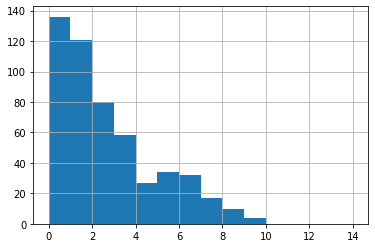

In [18]:
test_min_rmsd.hist(bins=np.arange(0,15))

In [27]:
with open('../data/docked_pose_labels.json') as f:
    docked_pose_labels = json.load(f)

In [31]:
pdbbind_test_set_pk = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
with open('../results/pdbbind_test_set_results_protein_similarity.json') as f:
    predicted = json.load(f)
max_score = {}

for f in predictions:
    max_score[f] = {}
    for c in predictions[f]:
        max_score[f][c] = {}
        for pdb in test_pdbs:
            scores = [predicted[f][c][label] for label in docked_pose_labels[pdb]]
            max_score[f][c][pdb] = np.max(scores)
        max_score[f][c] = pd.Series(max_score[f][c])
        
max_score_pearsonr = {}
for f in predictions:
    max_score_pearsonr[f] = {}
    for c in predictions[f]:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_pearsonr[f] = pd.Series(max_score_pearsonr[f])

In [41]:
for f in predictions:
    y_pred = pd.Series(max_score[f]['All']).loc[pdbbind_test_set_pk.index].values.ravel()
    y_true = pdbbind_test_set_pk.values.ravel()
    errors = np.abs(y_true - y_pred)
    test_set_rmsd = test_min_rmsd.loc[pdbbind_test_set_pk.index].values.ravel()
    print(f, *bootstrap_pearsonr(test_set_rmsd, errors))
    print(f, permutation_pearsonr(test_set_rmsd, errors)[1])

LB -0.07047778917613276 -0.1506326172935119 0.011534562008798297
LB 0.9466053394660534
SB -0.09058362425167137 -0.17108099059397164 -0.00732051136018002
SB 0.9821017898210179
HB -0.07181677628448835 -0.15406830587122894 0.013239849423693181
HB 0.9498050194980502


In [43]:
#y_true = pdbbind_test_set_pk.loc[pdbbind_test_set]

vina_docked_scores = pd.read_csv('../results/vina_docked_predicted_pk.csv', index_col=0, squeeze=True)

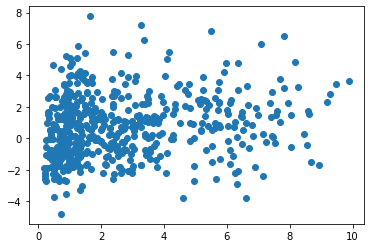

In [49]:
from matplotlib import pyplot as plt
diff = pdbbind_test_set_pk - vina_docked_scores.loc[pdbbind_test_set_pk.index]
plt.scatter(test_set_rmsd, diff)

In [46]:
plt.scatter()

0
4pcs    2.285566
1sl3    3.930694
3kwa    0.855935
3bv9   -0.757665
3ueu    0.701152
          ...   
4ivb    1.565473
2wn9    3.017194
1rnt    1.459008
2jdm    1.235365
4gr0    1.802865
Length: 519, dtype: float64